In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
import itertools
import warnings
warnings.filterwarnings("ignore")

In [5]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

In [6]:
# Set up Yahoo Finance data source
yf.pdr_override()

In [7]:
symbol = "ZW=F"
start_date = "2010-01-01"
end_date = None  # Use None for the current date

# Get historical stock data
stock_data = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [8]:
# Extract closing prices
closing_prices = stock_data["Close"]

# Divide data into training and testing sets
train_data = closing_prices[:int(len(closing_prices) * 0.8)]
test_data = closing_prices[int(len(closing_prices) * 0.8):]
check_stationarity(closing_prices)

# Step 2: Apply log transformation
log_closing_prices = np.log(closing_prices).dropna()

# Step 3: Differencing the log-transformed series
log_diff_closing_prices = log_closing_prices.diff().dropna()

# Step 4: Check stationarity again
check_stationarity(log_diff_closing_prices)


ADF Statistic: -2.555123
p-value: 0.102632
Series is not stationary
ADF Statistic: -31.169304
p-value: 0.000000
Series is stationary


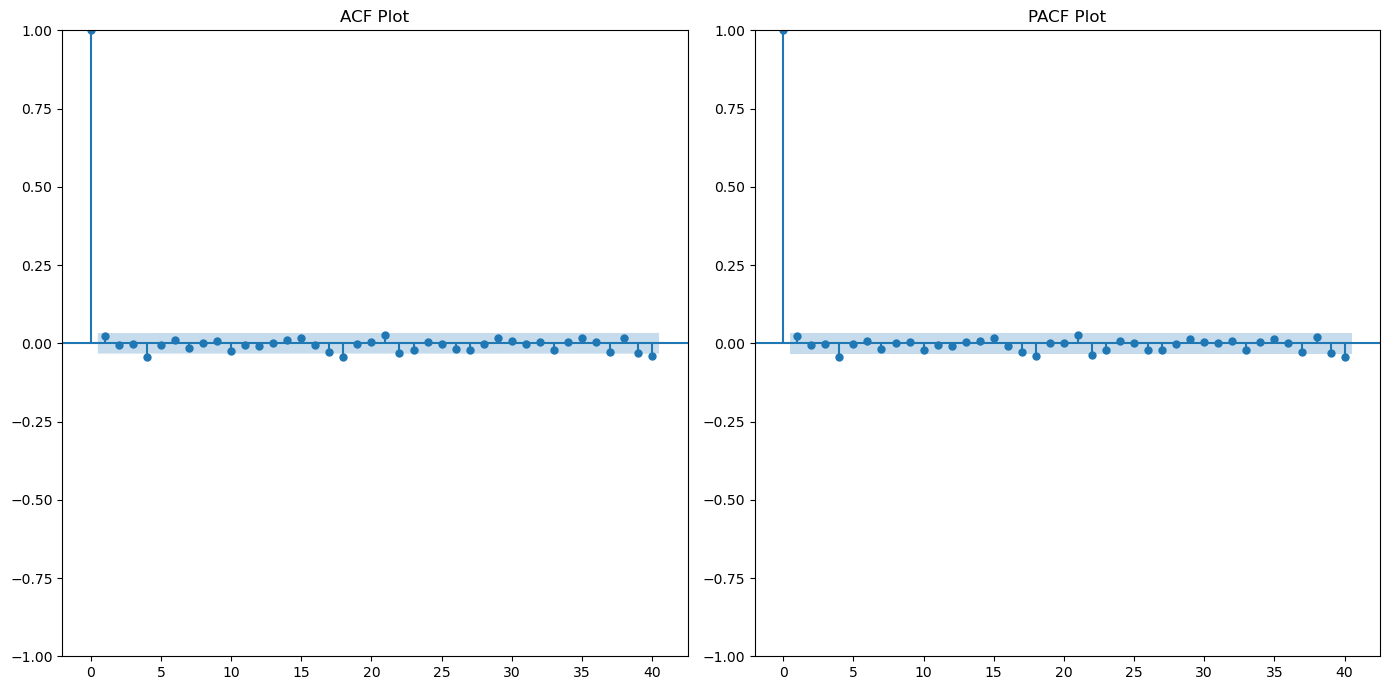

In [9]:
# Generate ACF plot
plt.figure(figsize=(14, 7))
plt.subplot(121)  # 1 row, 2 columns, 1st subplot
plot_acf(log_diff_closing_prices, ax=plt.gca(), lags=40)
plt.title('ACF Plot')

# Generate PACF plot
plt.subplot(122)  # 1 row, 2 columns, 2nd subplot
plot_pacf(log_diff_closing_prices, ax=plt.gca(), lags=40)
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

In [10]:
# Define ranges for non-seasonal ARIMA parameters
p_values = range(0, 3)
d_values = range(0, 3)  # Adjust as needed
q_values = range(0, 3)

pdq_combinations = list(itertools.product(p_values, d_values, q_values))
#SARIMA does not work for Gold predictions in this context
# Define ranges for seasonal ARIMA parameters
#P_values = range(0, 3)  # Adjust as needed
#D_values = range(0, 3)  # Adjust as needed
#Q_values = range(0, 3)  # Adjust as needed
#s = 12  # Assuming monthly data

# Generate random samples from the parameter space
#num_samples = 10
#random_p_values = np.random.choice(list(p_values), num_samples)
#random_d_values = np.random.choice(list(d_values), num_samples)
#random_q_values = np.random.choice(list(q_values), num_samples)
#random_P_values = np.random.choice(list(P_values), num_samples)
#random_D_values = np.random.choice(list(D_values), num_samples)
#random_Q_values = np.random.choice(list(Q_values), num_samples)

In [11]:
best_aic = float("inf")
best_order = None
best_model = None

for order in pdq_combinations:
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except Exception as e:
        continue

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Forecast stock prices
predictions = best_model.forecast(steps=len(test_data))

# Compute Root Mean Square Error (RMSE)
rmse = sqrt(mean_squared_error(test_data, predictions))

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data, predictions)
# Alternative MAPE calculation avoiding division by zero directly
mape_sum = 0
count = 0
for actual, pred in zip(test_data, predictions):
    if actual != 0:
        mape_sum += abs((actual - pred) / actual)
        count += 1
mape = (mape_sum / count) * 100 if count > 0 else None
#mape = np.mean(np.abs((test_data - predictions) / test_data)) * 100

# Compute root mean squared error (RMSE)
rmse = sqrt(mean_squared_error(test_data, predictions))
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, MAPE: {mape:.3f}%, Best ARIMA Order: {best_order}")

RMSE: 172.571, MAE: 123.191, MAPE: 14.935%, Best ARIMA Order: (1, 1, 1)


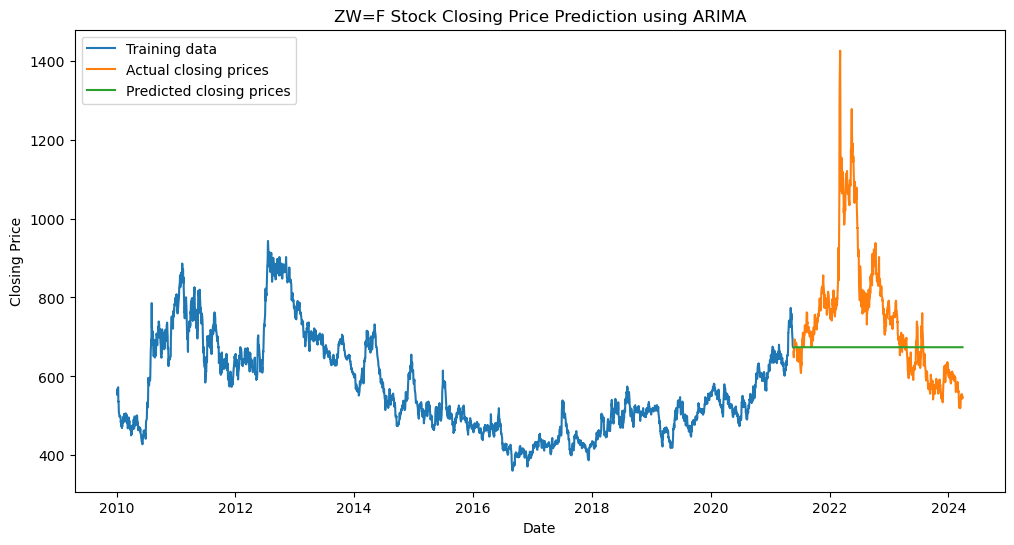

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Training data")
plt.plot(test_data, label="Actual closing prices")
plt.plot(test_data.index, predictions, label="Predicted closing prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"{symbol} Stock Closing Price Prediction using ARIMA")
plt.legend()
plt.show()

In [ ]:
from datetime import datetime, timedelta

# Assuming today's date for the context of this prediction
last_known_date = pd.to_datetime(stock_data.index[-1]).date()
steps_to_forecast = 1
# Forecasting the next available price
next_day_forecast = best_model.get_forecast(steps=steps_to_forecast)
next_day_price = next_day_forecast.predicted_mean.iloc[-1]  # Get the last forecast if steps_to_forecast > 1

print(f"Predicted wheat price for the next trading day: {next_day_price}")
import pickle

with open(r'C:\Users\jackc\Documents\FYP_ML_Predict\models\ARIMA_Wheat.pkl', 'wb') as pkl:
    pickle.dump(next_day_price, pkl)